In [4]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

model = load_model("GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth", device="cpu")
IMAGE_PATH = "example.jpg"
TEXT_PROMPT = "free standing rock."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device = 'cpu'
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite("annotated_image.jpg", annotated_frame)

final text_encoder_type: bert-base-uncased


True

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from groundingdino.util.inference import load_model, predict, annotate
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
import torchvision.transforms as T
from PIL import Image



# Load the GroundingDINO model
model = load_model("GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth", device="CPU")


final text_encoder_type: bert-base-uncased


In [6]:
class OrthomosaicDataset(torch.utils.data.Dataset):
    def __init__(self, tif_path, window_size=512, patch_size=14):
        self.src = rasterio.open(tif_path)
        self.window_size = window_size
        self.patch_size = patch_size
        self.n_windows_h = self.src.height // window_size
        self.n_windows_w = self.src.width // window_size
        
        # Define transform to match GroundingDino's requirements
        self.transform = T.Compose([
            T.Resize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return self.n_windows_h * self.n_windows_w

    def __getitem__(self, idx):
        h_idx = idx // self.n_windows_w
        w_idx = idx % self.n_windows_w
        window = Window(w_idx * self.window_size, h_idx * self.window_size,
                       self.window_size, self.window_size)
        image = self.src.read(window=window)
        
        # Convert to RGB if necessary
        if image.shape[0] == 4:
            image = image[:3, :, :]
            
        # Convert to PIL Image format
        image = np.transpose(image, (1, 2, 0))
        image_source = Image.fromarray((image * 255).astype(np.uint8))
        
        # Apply transform
        image_transformed = self.transform(image_source)
        
        return image, image_transformed


In [20]:
def visualize_predictions(dataset, model, num_samples=10, text_prompt="rock.", 
                         box_threshold=0.10, text_threshold=0.25, specific_tile=None):
    if specific_tile is not None:
        # If a specific tile is provided, set num_samples to 1
        num_samples = 1
        random_indices = [specific_tile]
    else:
        n_rows = int(np.ceil(np.sqrt(num_samples)))
        n_cols = int(np.ceil(num_samples / n_rows))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
        axes = axes.flatten()
        random_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(tqdm(random_indices)):
        image_source, image_transformed = dataset[idx]
        
        # Run inference
        boxes, logits, phrases = predict(
            model=model,
            image=image_transformed,
            caption=text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device='cpu'
        )
        
        # Annotate and display
        annotated_frame = annotate(image_source=image_source, 
                                 boxes=boxes, 
                                 logits=logits, 
                                 phrases=phrases)
        
        if specific_tile is not None:
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Tile {idx}')
            plt.show()
        else:
            axes[i].imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f'Tile {idx}')

    if specific_tile is None:
        plt.tight_layout()


In [15]:
# Parameters
TIF_PATH = "/Volumes/Deep's SSD/RA/Courtwright - Wishon SfM/Courtwright Stop 7/Main and Detail Rodney's Data/CW_Stop7_main_and_detail_ortho_11N.tif"
TEXT_PROMPT = "rock."
BOX_THRESHOLD = 0.10
TEXT_THRESHOLD = 0.25
WINDOW_SIZE = 512
NUM_TILES = 20


# Create dataset
dataset = OrthomosaicDataset(TIF_PATH, WINDOW_SIZE)


100%|██████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.94s/it]


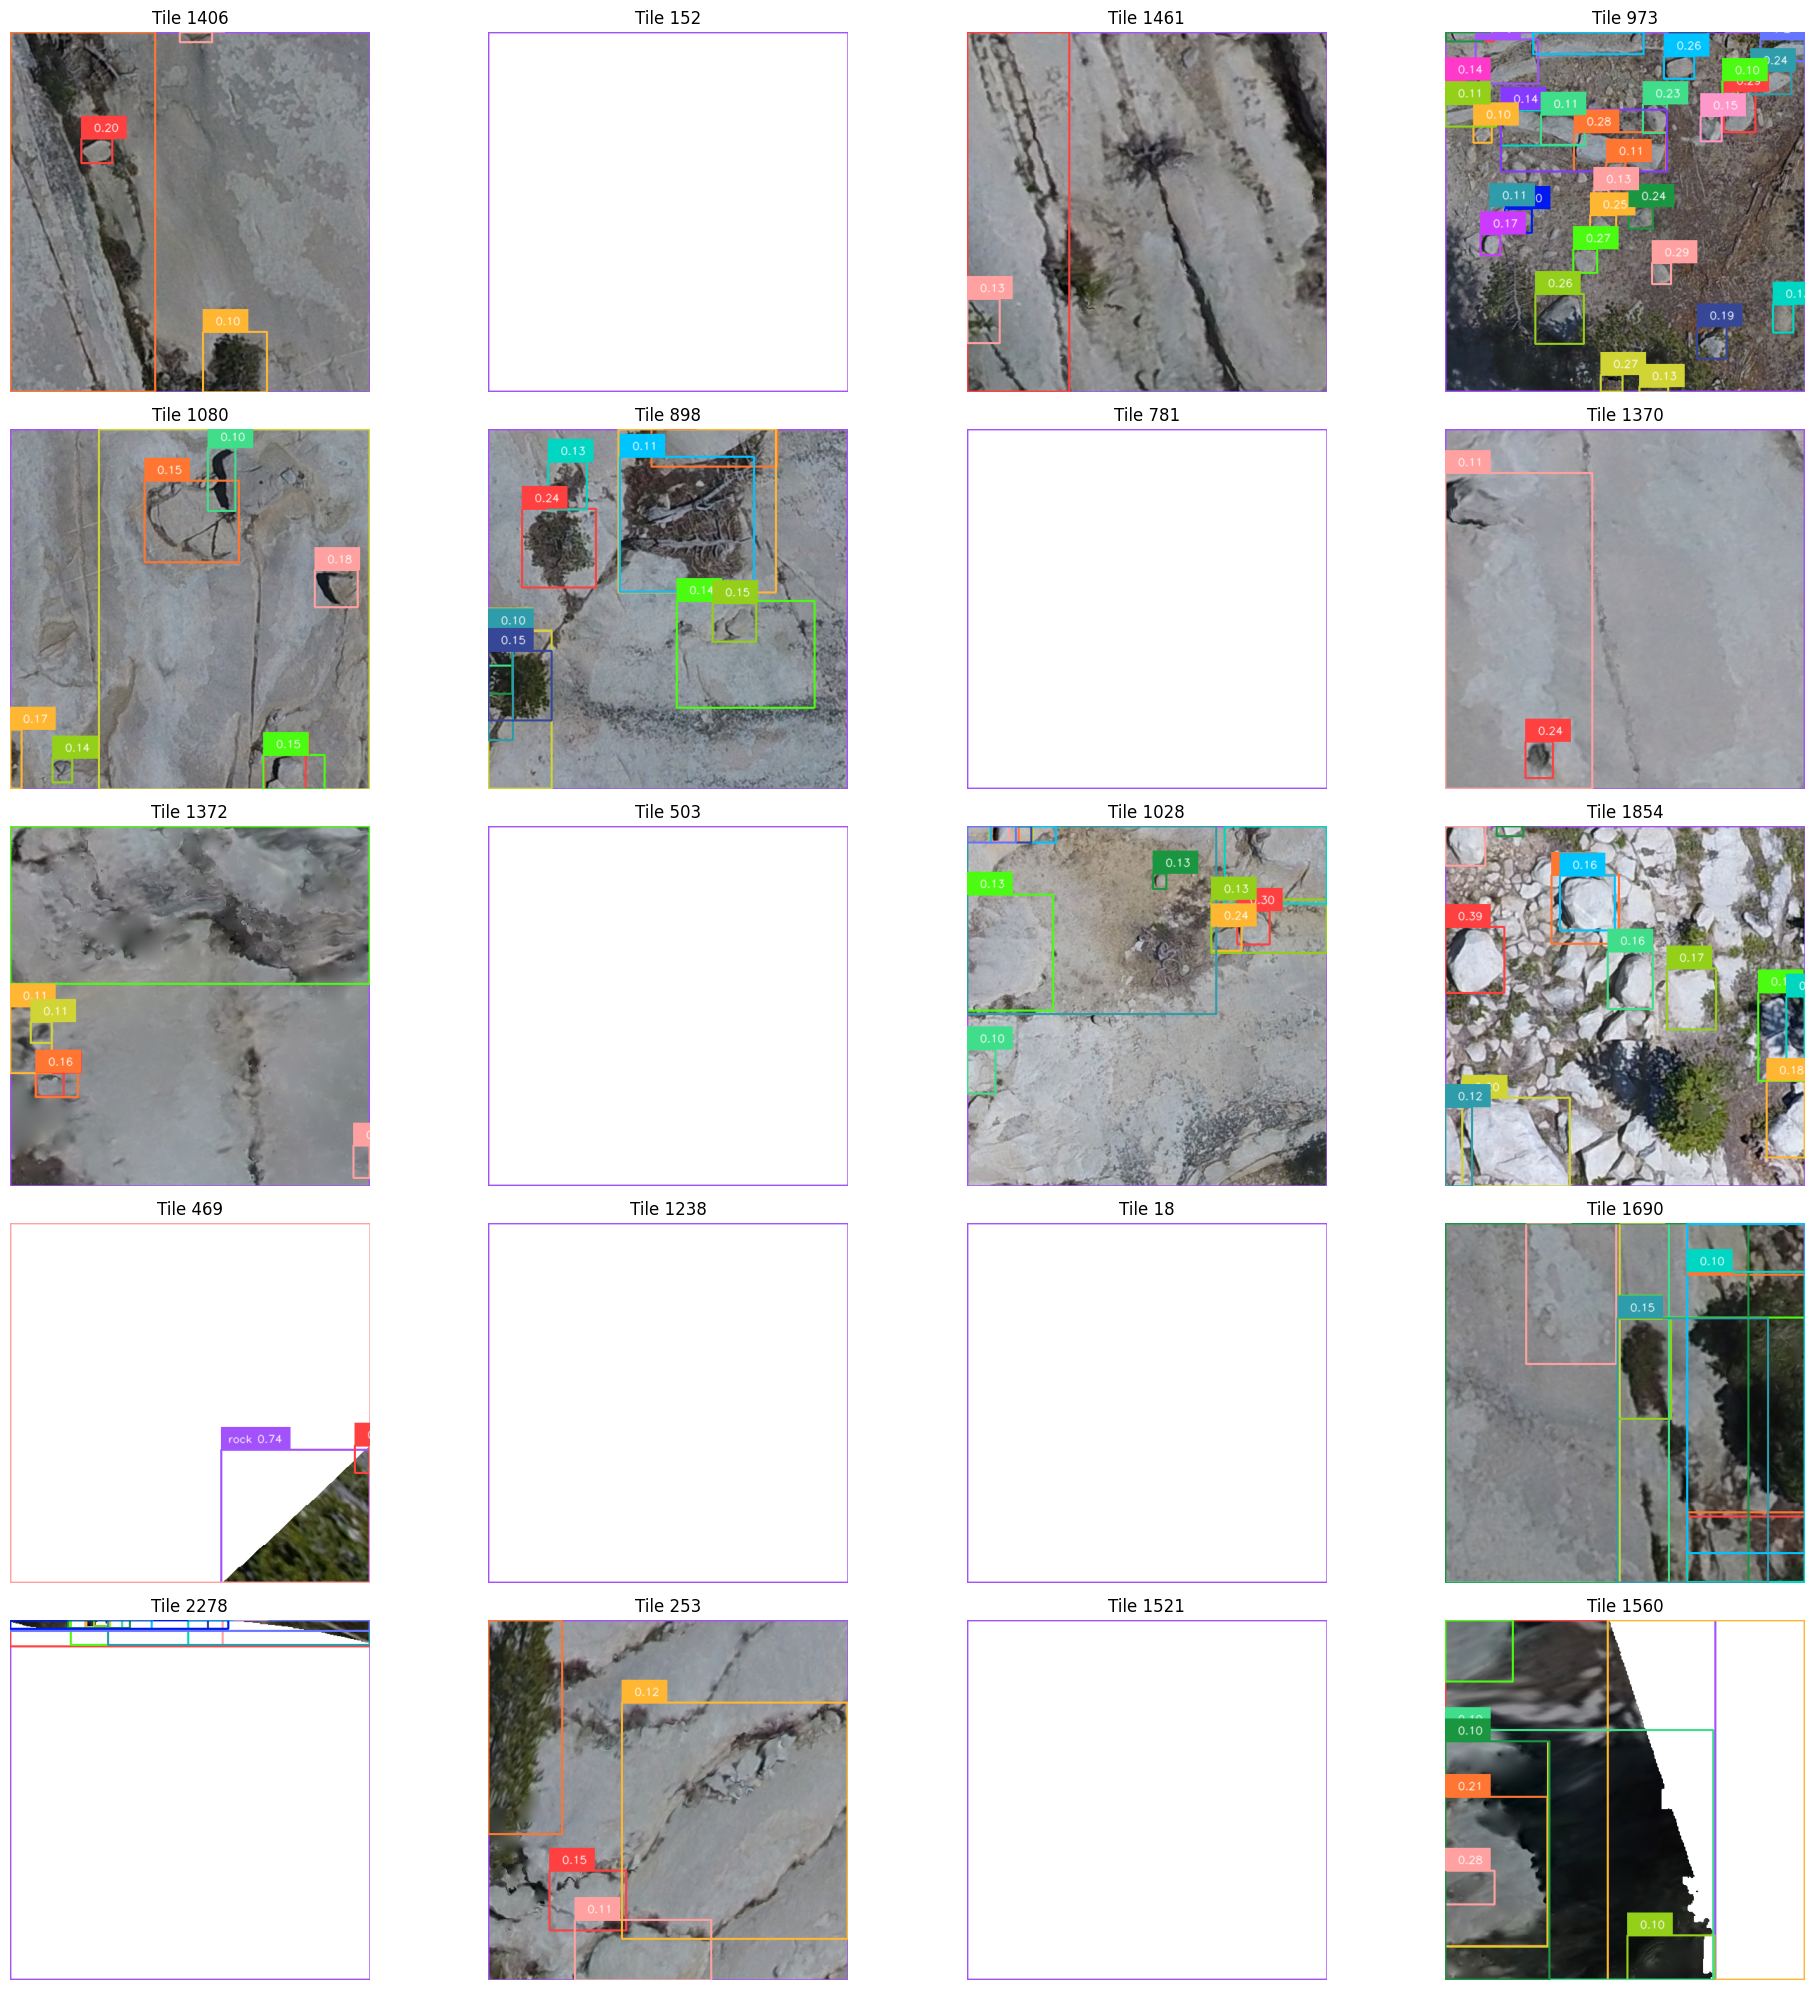

In [16]:

# Inference
visualize_predictions(
    dataset, 
    model, 
    NUM_TILES, 
    TEXT_PROMPT, 
    BOX_THRESHOLD, 
    TEXT_THRESHOLD, 
    # specific_tile= 1181
)

In [ ]:
import numpy as np
import torch
from groundingdino.util.inference import predict, annotate
from rasterio.windows import Window
from rasterio.transform import Affine
import geopandas as gpd
from shapely.geometry import Polygon


def extract_georef_bounding_boxes(dataset, model, text_prompt="rock.", 
                                  box_threshold=0.35, text_threshold=0.25):
    """
    Extract bounding boxes in georeferenced coordinates using Grounding DINO.
    
    Args:
        dataset: OrthomosaicDataset object.
        model: Loaded Grounding DINO model.
        text_prompt: Text prompt for object detection.
        box_threshold: Confidence threshold for bounding boxes.
        text_threshold: Confidence threshold for text association.

    Returns:
        GeoDataFrame containing georeferenced bounding boxes and associated metadata.
    """
    georef_boxes = []

    for idx in range(len(dataset)):
        # Get the source image and transformed image for inference
        image_source, image_transformed = dataset[idx]
        
        # Run inference with Grounding DINO
        boxes, logits, phrases = predict(
            model=model,
            image=image_transformed,
            caption=text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device='cpu'
        )
        
        # If no boxes are detected, skip this tile
        if len(boxes) == 0:
            continue
        
        # Convert pixel-based bounding boxes to geospatial coordinates
        h_idx = idx // dataset.n_windows_w
        w_idx = idx % dataset.n_windows_w
        window_transform = Affine.translation(w_idx * dataset.window_size, h_idx * dataset.window_size) * dataset.src.transform
        
        for box in boxes:
            # Convert box from (x_min, y_min, x_max, y_max) to geospatial coordinates
            x_min, y_min, x_max, y_max = box
            top_left = window_transform * (x_min, y_min)
            bottom_right = window_transform * (x_max, y_max)
            
            # Create a polygon representing the bounding box in geospatial space
            polygon = Polygon([
                top_left,
                (bottom_right[0], top_left[1]),
                bottom_right,
                (top_left[0], bottom_right[1]),
                top_left
            ])
            
            # Append results to the list with associated metadata
            georef_boxes.append({
                "geometry": polygon,
                "phrase": phrases[np.argmax(logits)],
                "confidence": np.max(logits)
            })
    
    # Create a GeoDataFrame to store georeferenced bounding boxes
    gdf = gpd.GeoDataFrame(georef_boxes, crs=dataset.src.crs)
    
    return gdf


# Example usage:
# Extract georeferenced bounding boxes from the dataset using Grounding DINO
georef_boxes_gdf = extract_georef_bounding_boxes(
    dataset=dataset,
    model=model,
    text_prompt=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)

# Save the GeoDataFrame to a shapefile or GeoJSON for further analysis or visualization
output_path = "georef_bounding_boxes.shp"
georef_boxes_gdf.to_file(output_path)

print(f"Georeferenced bounding boxes saved to {output_path}")


In [42]:
!pip install geopandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 11.1 MB/s eta 0:00:0031m9.9 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 16.4 MB/s eta 0:00:0031m16.5 MB/s eta 0:00:01



Processing Tile 973
Raw detection boxes (pixel coordinates): tensor([[ 3.6499e-02,  5.1880e-04,  5.1204e+02,  5.1200e+02],
        [ 3.9614e+02,  8.4435e+01,  4.4133e+02,  1.4241e+02],
        [ 2.9417e+02,  3.2815e+02,  3.2129e+02,  3.5866e+02],
        [ 1.8387e+02,  1.4254e+02,  3.1499e+02,  1.9818e+02],
        [ 2.0687e+02,  2.6080e+02,  2.4381e+02,  2.9881e+02],
        [ 2.2106e+02,  4.8732e+02,  2.5297e+02,  5.1199e+02],
        [ 1.8242e+02,  3.0869e+02,  2.1632e+02,  3.4275e+02],
        [ 1.2817e+02,  3.7225e+02,  1.9734e+02,  4.4383e+02],
        [ 2.8183e+02,  1.0266e+02,  3.1545e+02,  1.4310e+02],
        [ 2.6163e+02,  2.4885e+02,  2.9590e+02,  2.7999e+02],
        [ 7.9811e+01,  1.1124e+02,  1.9852e+02,  1.6130e+02],
        [ 4.3426e+02,  5.5152e+01,  4.9222e+02,  8.8491e+01],
        [ 3.1153e+02,  3.4024e+01,  3.5424e+02,  6.6320e+01],
        [ 3.5897e+02,  4.1805e+02,  4.0094e+02,  4.6445e+02],
        [ 4.4811e+02,  1.0889e+01,  5.1197e+02,  4.1746e+01],
        

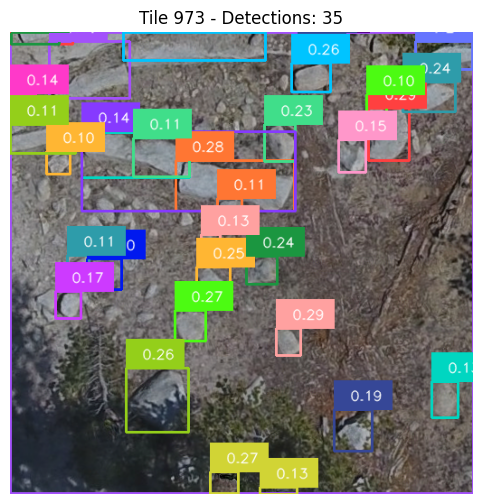

In [17]:
import numpy as np
import torch
from groundingdino.util.inference import predict, annotate
from rasterio.windows import Window
from rasterio.transform import Affine
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer
from torchvision.ops import box_convert

def process_single_tile(dataset, model, tile_idx, text_prompt="rock.", 
                       box_threshold=0.35, text_threshold=0.25):
    """
    Process a single tile and print all detection details with georeferenced coordinates
    in WGS 84 UTM Zone 11 North (EPSG:32611).
    """
    # Get the specific tile
    image_source, image_transformed = dataset[tile_idx]
    h, w, _ = image_source.shape  # Tile dimensions
    
    # Run Grounding DINO inference
    boxes, logits, phrases = predict(
        model=model,
        image=image_transformed,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        device='cpu'
    )
    boxes_original = boxes
    logits_original = logits
    phrases_original = phrases
    
    # Scale bounding boxes from normalized coordinates to pixel coordinates
    boxes = boxes * torch.Tensor([w, h, w, h])
    
    # Convert from cxcywh to xyxy format
    xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

    print(f"\n{'='*50}\nProcessing Tile {tile_idx}\n{'='*50}")
    print(f"Raw detection boxes (pixel coordinates): {xyxy_boxes}")
    print(f"Detection logits: {logits}")
    print(f"Phrases: {phrases}\n")
    
    # Correctly calculate window transform for georeferencing
    h_idx = tile_idx // dataset.n_windows_w
    w_idx = tile_idx % dataset.n_windows_w
    window_transform = (
        dataset.src.transform *
        Affine.translation(w_idx * dataset.window_size, h_idx * dataset.window_size)
    )
    
    print("Affine Transformation Matrix:", window_transform)

    # Define source and target CRS
    print("Source CRS:", dataset.src.crs)
    source_crs = dataset.src.crs  # Example: "EPSG:4326"
    target_crs = "EPSG:32611"
    
    # Initialize transformer
    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    
    # Test georeferencing transformation
    georeferenced_coords = []
    for i, box in enumerate(xyxy_boxes.numpy()):
        x_min, y_min = box[:2]
        try:
            geo_coord = tuple(map(float, window_transform * (x_min, y_min)))
            georeferenced_coords.append(geo_coord)
        except Exception as e:
            print(f"Error in georeferencing for Detection {i + 1}: {e}")
            georeferenced_coords.append((float('inf'), float('inf')))
    
    print("Georeferenced Coordinates:", georeferenced_coords)

    # Test UTM transformation
    utm_coords = []
    for i, coord in enumerate(georeferenced_coords):
        try:
            utm_coord = transformer.transform(*coord)
            utm_coords.append(utm_coord)
            print(f"Detection {i + 1} UTM Coord: {utm_coord}")
        except Exception as e:
            print(f"Error in CRS transformation for Detection {i + 1}: {e}")
            utm_coords.append((float('inf'), float('inf')))
    
    # Process and print each detection
    if len(xyxy_boxes) > 0:
        print(f"Found {len(xyxy_boxes)} detections:")
        for i, (box, confidence) in enumerate(zip(xyxy_boxes.numpy(), logits)):
            x_min, y_min, x_max, y_max = box
            
            # Convert pixel coordinates to georeferenced coordinates
            geo_min = tuple(map(float, window_transform * np.array([x_min, y_min])))
            geo_max = tuple(map(float, window_transform * np.array([x_max, y_max])))
            
            # Reproject coordinates to EPSG:32611
            geo_min_utm = transformer.transform(*geo_min)
            geo_max_utm = transformer.transform(*geo_max)
            
            print(f"\nDetection {i + 1}:")
            print(f"• Pixel Coordinates: ({x_min:.1f}, {y_min:.1f}) - ({x_max:.1f}, {y_max:.1f})")
            print(f"• Georeferenced Coordinates (Original): {geo_min} - {geo_max}")
            print(f"• Georeferenced Coordinates (UTM): {geo_min_utm} - {geo_max_utm}")
    

            
            # Create polygon for visualization in UTM
            poly_utm = Polygon([
                geo_min_utm,
                (geo_max_utm[0], geo_min_utm[1]),
                geo_max_utm,
                (geo_min_utm[0], geo_max_utm[1]),
                geo_min_utm
            ])
            print(f"• WKT Polygon (UTM): {poly_utm.wkt}")
    else:
        print("No detections found in this tile")
    
    # Visualize results


    annotated_frame = annotate(image_source=image_source, 
                                boxes=boxes_original, 
                                logits=logits_original, 
                                phrases=phrases_original)


    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Tile {tile_idx} - Detections: {len(xyxy_boxes)}')
    plt.axis('off')
    plt.show()
    
    return xyxy_boxes.numpy(), logits.numpy(), phrases

# Example usage with tile 973
SINGLE_TILE_IDX = 973
detection_boxes_xyxy, detection_logits, detection_phrases = process_single_tile(
    dataset=dataset,
    model=model,
    tile_idx=SINGLE_TILE_IDX,
    text_prompt=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD
)



In [54]:
# Code to check and convert EPSG



import rasterio
from pyproj import Transformer, CRS

def get_epsg(tif_path):
    """
    Get the EPSG code of a TIFF file.

    Args:
        tif_path (str): Path to the TIFF file.

    Returns:
        int or None: The EPSG code if available, otherwise None.
    """
    with rasterio.open(tif_path) as src:
        return src.crs.to_epsg()


def convert_and_get_epsg(tif_path, target_epsg):
    """
    Convert the coordinates of a TIFF file to the desired CRS and print both original and converted EPSG codes.

    Args:
        tif_path (str): Path to the TIFF file.
        target_epsg (int): Desired EPSG code for conversion.

    Returns:
        None
    """
    with rasterio.open(tif_path) as src:
        # Get the source CRS and EPSG
        source_crs = src.crs
        source_epsg = source_crs.to_epsg()
        print(f"Original EPSG: {source_epsg}")

        # Define the target CRS
        target_crs = CRS.from_epsg(target_epsg)
        
        # Create a transformer to convert coordinates
        transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

        # Get bounds of the raster in the source CRS
        bounds = src.bounds
        print(f"Original Bounds: {bounds}")

        # Convert bounds to the target CRS
        bottom_left = transformer.transform(bounds.left, bounds.bottom)
        top_right = transformer.transform(bounds.right, bounds.top)

        print(f"\n----Converting to EPSG 32611, that is WGS 84 UTM Zone 11 North---- \n")

        # Print converted coordinates and confirm target EPSG
        print(f"Bottom Left: {bottom_left}")
        print(f"Top Right: {top_right}")

        # Confirm the target EPSG code
        converted_epsg = target_crs.to_epsg()
        print(f"Converted EPSG: {converted_epsg}")


# Example usage
tif_path = TIF_PATH
target_epsg = 32611  # WGS 84 UTM Zone 11 North

try:
    print("Checking original EPSG...")
    original_epsg = get_epsg(tif_path)
    if original_epsg:
        print(f"The original EPSG code is: {original_epsg}")
    else:
        print("The TIFF file does not have an EPSG code.")

    print("\nConverting coordinates...")
    convert_and_get_epsg(tif_path, target_epsg)

except ModuleNotFoundError:
    print("The 'rasterio' module is not installed. Please install it using 'pip install rasterio'.")
except Exception as e:
    print(f"An error occurred: {e}")


Checking original EPSG...
The original EPSG code is: 4326

Converting coordinates...
Original EPSG: 4326
Original Bounds: BoundingBox(left=-118.9784607772078, bottom=37.07225731047853, right=-118.9739971195198, top=37.07615791368253)

----Converting to EPSG 32611, that is WGS 84 UTM Zone 11 North---- 

Bottom Left: (324121.41719699645, 4104719.1040467815)
Top Right: (324527.257251983, 4105143.632168669)
Converted EPSG: 32611


In [1]:
tiff_with_UTM = "/Volumes/Deep's SSD/RA/Courtwright - Wishon SfM/Courtwright Stop 1/CW24_Stop1_ortho_11N.tif"

In [12]:
from pyproj import Transformer, CRS
import rasterio

def get_epsg(tif_path):
    with rasterio.open(tif_path) as src:
        return src.crs.to_epsg()

print("The ESPG of the TIFF file is: ", get_epsg(TIF_PATH))


The ESPG of the TIFF file is:  32611


In [ ]:
import numpy as np
import torch
from groundingdino.util.inference import predict, annotate
from rasterio.windows import Window
from rasterio.transform import Affine
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer
from torchvision.ops import box_convert
import geopandas as gpd
from shapely.geometry import box

def extract_bounding_boxes(dataset, model, text_prompt="rock.", 
                           box_threshold=0.15, text_threshold=0.25, output_path="output.geojson"):
    """
    Extract bounding boxes and map them to georeferenced coordinates.
    
    Parameters:
    - dataset: OrthomosaicDataset object
    - model: GroundingDINO model
    - text_prompt: Text prompt for inference
    - box_threshold: Confidence threshold for bounding boxes
    - text_threshold: Confidence threshold for text matching
    - output_path: Path to save the georeferenced bounding boxes
    
    Returns:
    - A GeoDataFrame containing georeferenced bounding boxes
    """
    results = []

    for idx in tqdm(range(len(dataset))):
        # Get image and transformed image
        image_source, image_transformed = dataset[idx]
        
        # Run inference
        boxes, logits, phrases = predict(
            model=model,
            image=image_transformed,
            caption=text_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device='cpu'
        )
        
        if len(boxes) == 0:
            continue  # Skip if no detections
        
        # Convert boxes to geospatial coordinates
        h, w, _ = image_source.shape
        boxes = boxes * torch.Tensor([w, h, w, h])
        xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
        
        # Calculate tile position in the mosaic
        h_idx = tile_index // dataset.n_windows_w
        w_idx = tile_index % dataset.n_windows_w
        x_offset = w_idx * dataset.window_size
        y_offset = h_idx * dataset.window_size
        
        results = []
        for i_box, box_coords in enumerate(xyxy_boxes):
            x_min, y_min, x_max, y_max = box_coords
            
            # Adjust for tile offset
            geo_xmin = x_min + x_offset
            geo_ymin = y_min + y_offset
            geo_xmax = x_max + x_offset
            geo_ymax = y_max + y_offset
            
            # Convert to geographic coordinates
            top_left = dataset.src.transform * (geo_xmin, geo_ymin)
            bottom_right = dataset.src.transform * (geo_xmax, geo_ymax)
            
            results.append({
                "geometry": box(top_left[0], top_left[1], bottom_right[0], bottom_right[1]),
                "confidence": logits[i_box].item(),
                "tile_index": tile_index
            })
        
    # Create a GeoDataFrame from results
    gdf = gpd.GeoDataFrame(results, crs=dataset.src.crs)
    
    # Save to file (GeoJSON format)
    gdf.to_file(output_path, driver="GeoJSON")
    
    return gdf


# Parameters for extraction and saving results
OUTPUT_PATH = "bounding_boxes.geojson"

# Extract bounding boxes and save results as GeoJSON with georeferenced coordinates
georeferenced_bboxes = extract_bounding_boxes(
    dataset=dataset,
    model=model,
    text_prompt=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    output_path=OUTPUT_PATH
)

print(f"Bounding boxes saved to {OUTPUT_PATH}")


  0%|                                                                    | 0/1 [00:00<?, ?it/s]

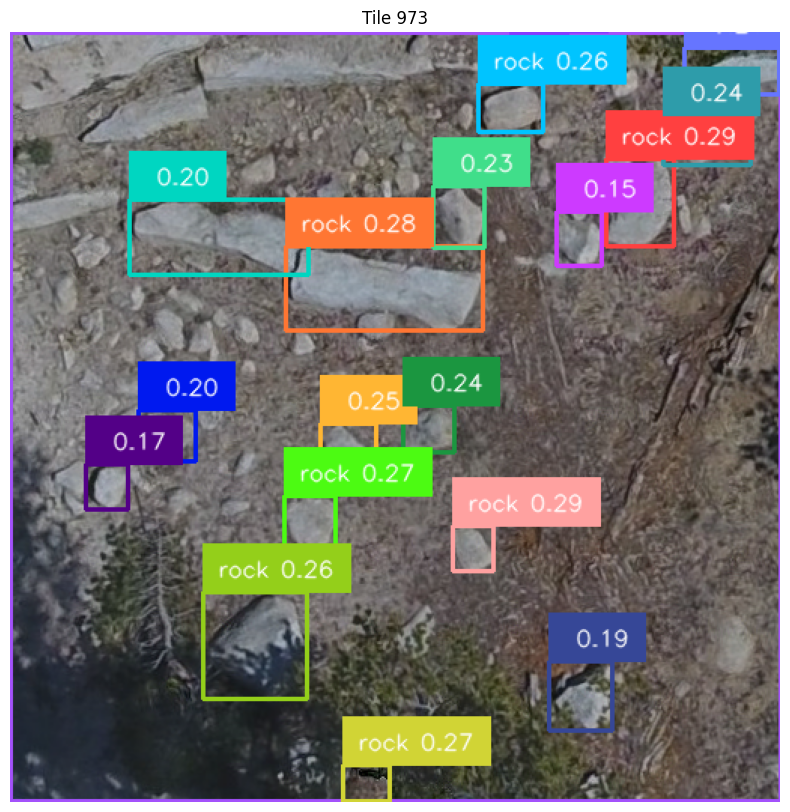

100%|████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.24s/it]

Georeferenced bounding boxes:
                                             geometry  confidence  tile_index
0   POLYGON ((324190.884 4104969.538, 324190.884 4...    0.546985         973
1   POLYGON ((324189.685 4104968.106, 324189.685 4...    0.288940         973
2   POLYGON ((324187.649 4104963.972, 324187.649 4...    0.291314         973
3   POLYGON ((324187.543 4104967.12, 324187.543 41...    0.284520         973
4   POLYGON ((324186.335 4104965.115, 324186.335 4...    0.245421         973
5   POLYGON ((324186.491 4104961.273, 324186.491 4...    0.274817         973
6   POLYGON ((324185.869 4104964.302, 324185.869 4...    0.273342         973
7   POLYGON ((324185.547 4104963.224, 324185.547 4...    0.263223         973
8   POLYGON ((324187.55 4104967.797, 324187.55 410...    0.234209         973
9   POLYGON ((324187.219 4104965.317, 324187.219 4...    0.237501         973
10  POLYGON ((324185.567 4104967.651, 324185.567 4...    0.204036         973
11  POLYGON ((324190.548 4104968.6

In [27]:

from torchvision.ops import box_convert
import geopandas as gpd
from shapely.geometry import box


def process_single_tile(dataset, model, tile_index, text_prompt="rock.", 
                       box_threshold=0.10, text_threshold=0.25):
    """
    Process a single tile and return both visualization and georeferenced boxes
    """
    # Get the specific tile
    image_source, image_transformed = dataset[tile_index]
    
    # Run inference
    boxes, logits, phrases = predict(
        model=model,
        image=image_transformed,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        device='cpu'
    )
    
    # Visualize results
    visualize_predictions(dataset, model,box_threshold=box_threshold, text_threshold=text_threshold, specific_tile=tile_index)
    
    if len(boxes) == 0:
        print("No detections found in this tile.")
        return None
    
    # Convert boxes to geospatial coordinates
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    
    # Calculate tile position in the mosaic
    h_idx = tile_index // dataset.n_windows_w
    w_idx = tile_index % dataset.n_windows_w
    x_offset = w_idx * dataset.window_size
    y_offset = h_idx * dataset.window_size
    
    geoboxes = []
    for i_box, box_coords in enumerate(xyxy_boxes):
        x_min, y_min, x_max, y_max = box_coords
        
        # Adjust for tile offset
        geo_xmin = x_min + x_offset
        geo_ymin = y_min + y_offset
        geo_xmax = x_max + x_offset
        geo_ymax = y_max + y_offset
        
        # Convert to geographic coordinates
        top_left = dataset.src.transform * (geo_xmin, geo_ymin)
        bottom_right = dataset.src.transform * (geo_xmax, geo_ymax)
        
        geoboxes.append({
            "geometry": box(top_left[0], top_left[1], bottom_right[0], bottom_right[1]),
            "confidence": logits[i_box].item(),
            "tile_index": tile_index
        })
    
    return gpd.GeoDataFrame(geoboxes, crs=dataset.src.crs)

# Choose a tile index to test (replace with your desired index)
TEST_TILE = 1181  # Example index from your visualization

# Process and visualize the specific tile
single_tile_results = process_single_tile(
    dataset=dataset,
    model=model,
    tile_index=973,
    text_prompt=TEXT_PROMPT,
    box_threshold=0.15,
    text_threshold=TEXT_THRESHOLD
)

# Display and save results
if single_tile_results is not None:
    print("Georeferenced bounding boxes:")
    print(single_tile_results)
    single_tile_results.to_file(f"tile_{TEST_TILE}_boxes.geojson", driver="GeoJSON")
    print(f"\nResults saved to tile_{TEST_TILE}_boxes.geojson")


In [33]:
import laspy
import geopandas as gpd
from shapely.geometry import box
import os

def extract_rock_patches(laz_path, bboxes_geojson, output_dir="rock_patches"):
    """
    Extract and save individual rock patches from LAZ file using georeferenced bounding boxes
    """
    os.makedirs(output_dir, exist_ok=True)
    gdf = gpd.read_file(bboxes_geojson)
    
    with laspy.open(laz_path) as las:
        las = las.read()
        
        for i, row in enumerate(gdf.itertuples()):
            minx, miny, maxx, maxy = row.geometry.bounds
            mask = (
                (las.x >= minx) & 
                (las.x <= maxx) & 
                (las.y >= miny) & 
                (las.y <= maxy)
            )
            
            # Get filtered points
            rock_points = las.points[mask]
            
            if len(rock_points) == 0:
                continue

            # Create new LasData with proper header handling
            sub_header = laspy.LasHeader.from_header(las.header)  # Correct header copy method
            sub_las = laspy.LasData(sub_header)
            sub_las.points = rock_points.copy()
            
            # Update header metadata automatically
            sub_las.update_header()
            
            output_path = os.path.join(output_dir, f"rock_patch_{i}.laz")
            sub_las.write(output_path)

            print(f"Saved {len(rock_points)} points to {output_path}")


# Usage
extract_rock_patches(
    laz_path="output_utm.laz",
    bboxes_geojson="tile_1181_boxes.geojson"
)


AttributeError: type object 'LasHeader' has no attribute 'from_header'

In [ ]:
import laspy
import geopandas as gpd
import numpy as np
import os

def extract_rocks_from_laz(geojson_path, laz_path, output_dir="rock_patches", padding=0.2):
    """
    Extract individual rock point clouds from LAZ using GeoJSON bounding boxes
    
    Parameters:
    - geojson_path: Path to GeoJSON with bounding boxes
    - laz_path: Path to input LAZ/LAS file
    - output_dir: Output directory for rock patches
    - padding: Additional buffer around bounding boxes (meters)
    """
    # Load data
    bboxes_gdf = gpd.read_file(geojson_path)
    pc = laspy.read(laz_path)
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Get CRS information
    pc_crs = pc.header.parse_crs()
    if bboxes_gdf.crs != pc_crs.to_epsg():
        raise ValueError(f"CRS mismatch: LAZ file has {pc_crs}, GeoJSON has {bboxes_gdf.crs}")

    # Processing function
    def box_filter(las, bounds, padding=0.2):
        x1, y1, x2, y2 = bounds
        x1 -= padding
        x2 += padding
        y1 -= padding
        y2 += padding
        
        x_mask = (las.x >= x1) & (las.x <= x2)
        y_mask = (las.y >= y1) & (las.y <= y2)
        mask = x_mask & y_mask
        
        return (
            las.x[mask], las.y[mask], las.z[mask],
            las.red[mask], las.green[mask], las.blue[mask]
        )

    # Process each rock
    for idx, row in bboxes_gdf.iterrows():
        # Get bounding box coordinates
        minx, miny, maxx, maxy = row.geometry.bounds
        bounds = (minx, miny, maxx, maxy)
        
        # Filter points
        rock_points = box_filter(pc, bounds, padding)
        
        # Skip empty point clouds
        if len(rock_points[0]) == 0:
            continue
            
        # Write to LAZ
        header = laspy.LasHeader(point_format=pc.header.point_format, version=pc.header.version)
        header.offsets = pc.header.offsets
        header.scales = pc.header.scales
        
        las = laspy.LasData(header)
        las.x = rock_points[0]
        las.y = rock_points[1]
        las.z = rock_points[2]
        las.red = rock_points[3]
        las.green = rock_points[4]
        las.blue = rock_points[5]
        
        output_path = os.path.join(output_dir, f"rock_{idx}.laz")
        las.write(output_path)

# Usage
extract_rocks_from_laz(
    geojson_path="tile_1181_boxes.geojson",  # From previous step
    laz_path="output_utm.laz",     # Your point cloud file
    padding=0.2                            # Increased padding for safety
)


In [2]:
import laspy
pc = laspy.read("output_utm.laz")

In [7]:
header = laspy.LasHeader(point_format=pc.header.point_format, version=pc.header.version)

In [8]:
laspy.LasData(header)

<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 0 points, 0 vlrs)>

In [5]:
import os
import numpy as np
import torch
import random 
import rasterio
import laspy
import geopandas as gpd
import torchvision.transforms as T
from tqdm import tqdm
from shapely.geometry import box
from rasterio.windows import Window
from torchvision.ops import box_convert
from groundingdino.util.inference import load_model, predict
from pyproj import CRS
from PIL import Image



# ----------------------------
# 1. Orthomosaic Processing
# ----------------------------

class OrthomosaicDataset(torch.utils.data.Dataset):
    def __init__(self, tif_path, window_size=512, blank_threshold=0.8):
        self.src = rasterio.open(tif_path)
        self.window_size = window_size
        self.blank_threshold = blank_threshold
        self.valid_indices = []
        self._precalculate_valid_indices()
        
        self.transform = T.Compose([
            T.Resize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def _precalculate_valid_indices(self):
        print("Scanning for valid tiles...")
        total_tiles = (self.src.height // self.window_size) * (self.src.width // self.window_size)
        
        for idx in tqdm(range(total_tiles), desc="Validating tiles"):
            h_idx = idx // (self.src.width // self.window_size)
            w_idx = idx % (self.src.width // self.window_size)
            window = Window(w_idx * self.window_size, 
                          h_idx * self.window_size,
                          self.window_size, 
                          self.window_size)
            
            try:
                tile = self.src.read(window=window)
                if self._is_valid_tile(tile):
                    self.valid_indices.append(idx)
            except rasterio.errors.RasterioIOError:
                continue
        print(f"\nFound {len(self.valid_indices)} valid tiles.")

    def _is_valid_tile(self, tile):
        if tile.shape[0] == 4:
            tile = tile[:3]
            
        tile_sum = np.sum(tile, axis=0)
        valid_pixels = np.sum(tile_sum > 0)
        return (valid_pixels / (self.window_size ** 2)) > (1 - self.blank_threshold)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        h_idx = actual_idx // (self.src.width // self.window_size)
        w_idx = actual_idx % (self.src.width // self.window_size)
        
        window = Window(w_idx * self.window_size,
                       h_idx * self.window_size,
                       self.window_size,
                       self.window_size)
        
        image = self.src.read(window=window)
        if image.shape[0] == 4:
            image = image[:3]
            
        image = np.transpose(image, (1, 2, 0))
        image_source = Image.fromarray((image * 255).astype(np.uint8))
        image_transformed = self.transform(image_source)
        
        return image, image_transformed, actual_idx

    def get_epsg(self):
        return self.src.crs.to_epsg()


# ----------------------------
# 2. Rock Detection
# ----------------------------

class RockDetector:
    def __init__(self, model_config, model_weights, device="cpu"):
        self.model = load_model(model_config, model_weights, device=device)
        
    def detect_rocks(self, dataset, text_prompt, box_thresh=0.15, text_thresh=0.25, max_tiles=None):
        results = []
        num_tiles = min(max_tiles, len(dataset)) if max_tiles else len(dataset)
        print(f"\nDetecting rocks in {num_tiles} random tiles...")
        
        # Select random indices from valid tiles
        selected_indices = random.sample(range(len(dataset)), num_tiles)
        
        for idx in tqdm(selected_indices, desc="Processing tiles"):
            image_source, image_transformed, actual_idx = dataset[idx]
            boxes, logits, _ = predict(
                model=self.model,
                image=image_transformed,
                caption=text_prompt,
                box_threshold=box_thresh,
                text_threshold=text_thresh,
                device='cpu'
            )
            
            if boxes.shape[0] > 0:
                results.extend(self._process_detections(dataset, actual_idx, boxes, logits, image_source.shape))
                
        return gpd.GeoDataFrame(results, crs=dataset.src.crs)

    def _process_detections(self, dataset, idx, boxes, logits, img_shape):
        h, w, _ = img_shape
        boxes = boxes * torch.Tensor([w, h, w, h])
        xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
        
        h_idx = idx // (dataset.src.width // dataset.window_size)
        w_idx = idx % (dataset.src.width // dataset.window_size)
        x_offset = w_idx * dataset.window_size
        y_offset = h_idx * dataset.window_size

        return [self._create_geobox(dataset, box, logit, idx, x_offset, y_offset) 
                for box, logit in zip(xyxy_boxes, logits)]

    def _create_geobox(self, dataset, box_coords, logit, idx, x_offset, y_offset):
        x_min, y_min, x_max, y_max = box_coords
        geo_xmin = x_min + x_offset
        geo_ymin = y_min + y_offset
        geo_xmax = x_max + x_offset
        geo_ymax = y_max + y_offset

        top_left = dataset.src.transform * (geo_xmin, geo_ymin)
        bottom_right = dataset.src.transform * (geo_xmax, geo_ymax)
        
        return {
            "geometry": box(top_left[0], bottom_right[1], bottom_right[0], top_left[1]),
            "confidence": logit.item(),
            "tile_index": idx
        }

# ----------------------------
# 3. Point Cloud Extraction
# ----------------------------

class PointCloudExtractor:
    def __init__(self, laz_path):
        self.laz_path = laz_path
        print(f"Loading point cloud from {laz_path}...")
        self.pc = laspy.read(laz_path)
        print(f"Loaded {len(self.pc)} points with CRS: {self.pc.header.parse_crs()}")
        print(f"Point cloud bounds:")
        print(f"X: {self.pc.x.min():.2f} to {self.pc.x.max():.2f}")
        print(f"Y: {self.pc.y.min():.2f} to {self.pc.y.max():.2f}")
        print(f"Z: {self.pc.z.min():.2f} to {self.pc.z.max():.2f}")
        
    def extract_rocks(self, geojson_path, output_dir="rock_patches", padding=0.2):
        os.makedirs(output_dir, exist_ok=True)
        bboxes_gdf = gpd.read_file(geojson_path)
        self._validate_crs(bboxes_gdf)
        
        print(f"\nExtracting {len(bboxes_gdf)} rock patches...")
        for idx, row in tqdm(bboxes_gdf.iterrows(), total=len(bboxes_gdf), desc="Extracting rocks"):
            self._process_rock(row, output_dir, padding)

    def _process_rock(self, row, output_dir, padding):
        minx, miny, maxx, maxy = row.geometry.bounds
        print(f"\nProcessing rock {row.name} with bounds:")
        print(f"Original: x={minx:.2f}-{maxx:.2f}, y={miny:.2f}-{maxy:.2f}")
        
        # Ensure valid coordinate order with padding
        x1 = min(minx, maxx) - padding
        x2 = max(minx, maxx) + padding
        y1 = min(miny, maxy) - padding
        y2 = max(miny, maxy) + padding
        
        print(f"Search area: x={x1:.2f}-{x2:.2f}, y={y1:.2f}-{y2:.2f}")
        
        # Check against point cloud bounds
        if (x2 < self.pc.x.min() or x1 > self.pc.x.max() or
            y2 < self.pc.y.min() or y1 > self.pc.y.max()):
            print("🚨 Bounding box completely outside point cloud coverage!")
            return
            
        mask = self._create_mask(x1, y1, x2, y2)
        
        if mask.sum() == 0:
            print("⚠️ No points found. Potential issues:")
            print(f"- Point cloud X range: {self.pc.x.min():.2f}-{self.pc.x.max():.2f}")
            print(f"- Point cloud Y range: {self.pc.y.min():.2f}-{self.pc.y.max():.2f}")
            print("- Check coordinate transformations between datasets")
            print("- Verify spatial alignment of orthomosaic and point cloud")
            return
            
        self._write_patch(mask, os.path.join(output_dir, f"rock_{row.name}.laz"))

    def _create_mask(self, x1, y1, x2, y2):
        return ((self.pc.x >= x1) & (self.pc.x <= x2) &
                (self.pc.y >= y1) & (self.pc.y <= y2))

    def _write_patch(self, mask, output_path):
        sub_header = laspy.LasHeader(point_format=self.pc.header.point_format, version=self.pc.header.version)
        sub_las = laspy.LasData(sub_header)
        sub_las.points = self.pc.points[mask].copy()
        sub_las.update_header()
        sub_las.write(output_path)

    def _validate_crs(self, gdf):
        pc_crs = self.pc.header.parse_crs().to_epsg()
        if gdf.crs.to_epsg() != pc_crs:
            raise ValueError(f"CRS mismatch: Point cloud {pc_crs} vs boxes {gdf.crs}")


# ----------------------------
# Main Pipeline
# ----------------------------

def run_pipeline(config):
    if 'dataset' in locals() or 'dataset' in globals():
        del dataset, detector, bboxes_gdf, extractor
    dataset = OrthomosaicDataset(config["tif_path"])
    detector = RockDetector(config["model_config"], config["model_weights"])
    print(f"TIFF CRS: EPSG:{dataset.get_epsg()}")

    bboxes_gdf = detector.detect_rocks(
        dataset,
        text_prompt=config["text_prompt"],
        box_thresh=config["box_thresh"],
        text_thresh=config["text_thresh"],
        max_tiles=config.get("max_tiles")
    )
    
    if not bboxes_gdf.empty:
        bboxes_gdf.to_file(config["output_geojson"], driver="GeoJSON")
        print(f"Saved {len(bboxes_gdf)} bounding boxes to {config['output_geojson']}")

        extractor = PointCloudExtractor(config["laz_path"])
        extractor.extract_rocks(
            geojson_path=config["output_geojson"],
            output_dir=config["output_dir"],
            padding=config["padding"]
        )
    print(f"\nPipeline completed successfully. Outputs in {config['output_dir']}")




In [6]:
# Configuration
CONFIG = {
    "tif_path": "/Volumes/Deep's SSD/RA/Courtwright - Wishon SfM/Courtwright Stop 7/Main and Detail Rodney's Data/CW_Stop7_main_and_detail_ortho_11N.tif",
    "laz_path": "/Users/deeprodge/Downloads/DREAMS/PG&E/rock_detection_3d/unsupervised_rock_detection_2d/CW_Stop7_main_and_detail_11N.laz",
    "model_config": "GroundingDINO_SwinT_OGC.py",
    "model_weights": "weights/groundingdino_swint_ogc.pth",
    "text_prompt": "rock.",
    "box_thresh": 0.15,
    "text_thresh": 0.25,
    "output_geojson": "detected_rocks.geojson",
    "output_dir": "box_pbr",
    "padding": 0.2,
    "max_tiles": 3  # To limit processing; for checking
}

run_pipeline(CONFIG)

Scanning for valid tiles...


Validating tiles: 100%|███████| 2300/2300 [00:14<00:00, 160.29it/s]



Found 2300 valid tiles.
final text_encoder_type: bert-base-uncased


TIFF CRS: EPSG:32611

Detecting rocks in 3 random tiles...


Processing tiles: 100%|██████████████| 3/3 [00:15<00:00,  5.29s/it]


Saved 22 bounding boxes to detected_rocks.geojson
Loading point cloud from /Users/deeprodge/Downloads/DREAMS/PG&E/rock_detection_3d/unsupervised_rock_detection_2d/CW_Stop7_main_and_detail_11N.laz...
Loaded 127336413 points with CRS: EPSG:32611
Point cloud bounds:
X: 324127.26 to 324519.61
Y: 4104714.91 to 4105147.18
Z: 2453.68 to 2552.45

Extracting 22 rock patches...


Extracting rocks:   0%|                     | 0/22 [00:00<?, ?it/s]


Processing rock 0 with bounds:
Original: x=324173.52-324182.20, y=4104874.02-4104882.70
Search area: x=324173.32-324182.40, y=4104873.82-4104882.90


Extracting rocks:   5%|▌           | 1/22 [02:32<53:19, 152.36s/it]


Processing rock 1 with bounds:
Original: x=324179.96-324180.72, y=4104877.70-4104878.43
Search area: x=324179.76-324180.92, y=4104877.50-4104878.63


Extracting rocks:   9%|█           | 2/22 [05:03<50:36, 151.82s/it]


Processing rock 2 with bounds:
Original: x=324181.68-324182.20, y=4104880.25-4104880.90
Search area: x=324181.48-324182.40, y=4104880.05-4104881.10


Extracting rocks:  14%|█▋          | 3/22 [07:25<46:38, 147.30s/it]


Processing rock 3 with bounds:
Original: x=324181.21-324182.04, y=4104881.89-4104882.70
Search area: x=324181.01-324182.24, y=4104881.69-4104882.90


Extracting rocks:  18%|██▏         | 4/22 [10:03<45:24, 151.37s/it]


Processing rock 4 with bounds:
Original: x=324174.13-324177.08, y=4104875.60-4104879.13
Search area: x=324173.93-324177.28, y=4104875.40-4104879.33


Extracting rocks:  23%|██▋         | 5/22 [12:55<45:01, 158.91s/it]


Processing rock 5 with bounds:
Original: x=324181.71-324182.20, y=4104879.28-4104880.00
Search area: x=324181.51-324182.40, y=4104879.08-4104880.20


Extracting rocks:  27%|███▎        | 6/22 [15:44<43:14, 162.16s/it]


Processing rock 6 with bounds:
Original: x=324177.62-324178.89, y=4104877.72-4104879.20
Search area: x=324177.42-324179.09, y=4104877.52-4104879.40


Extracting rocks:  32%|███▊        | 7/22 [18:37<41:28, 165.91s/it]


Processing rock 7 with bounds:
Original: x=324180.19-324180.77, y=4104876.12-4104876.76
Search area: x=324179.99-324180.97, y=4104875.92-4104876.96


Extracting rocks:  36%|████▎       | 8/22 [21:29<39:07, 167.71s/it]


Processing rock 8 with bounds:
Original: x=324179.47-324180.45, y=4104874.73-4104875.55
Search area: x=324179.27-324180.65, y=4104874.53-4104875.75


Extracting rocks:  41%|████▉       | 9/22 [24:23<36:48, 169.88s/it]


Processing rock 9 with bounds:
Original: x=324178.91-324179.59, y=4104877.62-4104878.13
Search area: x=324178.71-324179.79, y=4104877.42-4104878.33


Extracting rocks:  45%|█████      | 10/22 [25:52<28:58, 144.88s/it]


Processing rock 10 with bounds:
Original: x=324173.90-324174.84, y=4104880.12-4104881.01
Search area: x=324173.70-324175.04, y=4104879.92-4104881.21


Extracting rocks:  50%|█████▌     | 11/22 [26:44<21:19, 116.29s/it]


Processing rock 11 with bounds:
Original: x=324178.38-324179.35, y=4104878.55-4104879.77
Search area: x=324178.18-324179.55, y=4104878.35-4104879.97


Extracting rocks:  55%|██████▌     | 12/22 [27:07<14:40, 88.05s/it]


Processing rock 12 with bounds:
Original: x=324176.79-324177.87, y=4104877.67-4104878.80
Search area: x=324176.59-324178.07, y=4104877.47-4104879.00


Extracting rocks:  59%|███████     | 13/22 [27:19<09:43, 64.87s/it]


Processing rock 13 with bounds:
Original: x=324182.00-324182.20, y=4104878.62-4104879.23
Search area: x=324181.80-324182.40, y=4104878.42-4104879.43


Extracting rocks:  64%|███████▋    | 14/22 [27:55<07:29, 56.22s/it]


Processing rock 14 with bounds:
Original: x=324182.04-324182.20, y=4104877.37-4104877.83
Search area: x=324181.84-324182.40, y=4104877.17-4104878.03


Extracting rocks:  68%|████████▏   | 15/22 [28:06<04:58, 42.64s/it]


Processing rock 15 with bounds:
Original: x=324373.23-324381.92, y=4104856.65-4104865.34
Search area: x=324373.03-324382.12, y=4104856.45-4104865.54


Extracting rocks:  73%|████████▋   | 16/22 [28:18<03:19, 33.22s/it]


Processing rock 16 with bounds:
Original: x=324373.23-324374.87, y=4104863.05-4104865.34
Search area: x=324373.03-324375.07, y=4104862.85-4104865.54


Extracting rocks:  77%|█████████▎  | 17/22 [28:34<02:20, 28.12s/it]


Processing rock 17 with bounds:
Original: x=324303.77-324312.45, y=4104960.85-4104969.54
Search area: x=324303.57-324312.65, y=4104960.65-4104969.74


Extracting rocks:  82%|█████████▊  | 18/22 [28:45<01:31, 22.95s/it]


Processing rock 18 with bounds:
Original: x=324303.77-324308.27, y=4104966.34-4104969.54
Search area: x=324303.57-324308.47, y=4104966.14-4104969.74


Extracting rocks:  86%|██████████▎ | 19/22 [28:56<00:57, 19.32s/it]


Processing rock 19 with bounds:
Original: x=324306.62-324310.84, y=4104965.04-4104969.54
Search area: x=324306.42-324311.04, y=4104964.84-4104969.74


Extracting rocks:  91%|██████████▉ | 20/22 [29:06<00:33, 16.74s/it]


Processing rock 20 with bounds:
Original: x=324303.77-324308.43, y=4104960.85-4104967.99
Search area: x=324303.57-324308.63, y=4104960.65-4104968.19


Extracting rocks:  95%|███████████▍| 21/22 [29:18<00:15, 15.08s/it]


Processing rock 21 with bounds:
Original: x=324310.56-324312.45, y=4104965.78-4104969.55
Search area: x=324310.36-324312.65, y=4104965.58-4104969.75


Extracting rocks: 100%|████████████| 22/22 [29:29<00:00, 80.42s/it]



Pipeline completed successfully. Outputs in box_pbr
